Install Dependencies and Setup

In [1]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib


  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "c:\Users\akash\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\akash\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\akash\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
    

In [2]:
%pip list

Package                      Version
---------------------------- ------------
absl-py                      2.1.0
accelerate                   0.31.0
altair                       5.4.0
asgiref                      3.7.2
asttokens                    2.4.1
astunparse                   1.6.3
attrs                        24.2.0
bitsandbytes                 0.43.1
blinker                      1.7.0
cachetools                   5.4.0
certifi                      2023.7.22
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.8.5
decorator                    5.1.1
distlib                      0.3.7
Django                       4.2.3
einops                       0.8.0
executing                    2.0.1
filelock                     3.13.0
Flask                        3.0.0
Flask-Login                  0.6.3
Fl

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Remove dodgy images

In [6]:
import cv2
import imghdr

C:\Users\akash\AppData\Local\Temp\ipykernel_11136\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'Data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')


Found 199 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()


In [13]:
batch = data_iterator.next()


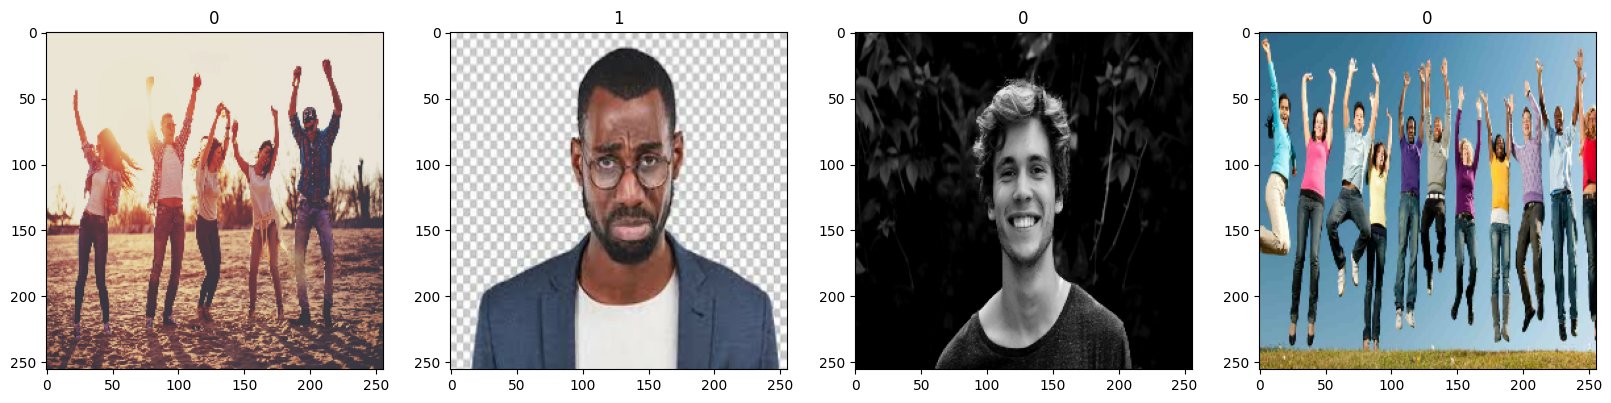

In [14]:

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Scale Data

In [15]:

data = data.map(lambda x,y: (x/255, y))

In [26]:
data.as_numpy_iterator().next()


(array([[[[2.52879888e-01, 3.31311285e-01, 2.25428924e-01],
          [2.25306377e-01, 3.03737760e-01, 1.96844369e-01],
          [2.06158087e-01, 2.86274523e-01, 1.71415448e-01],
          ...,
          [0.00000000e+00, 7.28247538e-02, 7.05882385e-02],
          [0.00000000e+00, 7.45098069e-02, 7.64093101e-02],
          [0.00000000e+00, 7.80943632e-02, 8.20159316e-02]],
 
         [[2.52879888e-01, 3.31311285e-01, 2.25428924e-01],
          [2.25796089e-01, 3.04227471e-01, 1.97823793e-01],
          [2.08873793e-01, 2.88174033e-01, 1.76846847e-01],
          ...,
          [0.00000000e+00, 6.33272082e-02, 6.10906854e-02],
          [0.00000000e+00, 6.50122538e-02, 6.69117644e-02],
          [0.00000000e+00, 6.85968101e-02, 7.25183859e-02]],
 
         [[2.49665856e-01, 3.26994300e-01, 2.22671568e-01],
          [2.24253699e-01, 3.01582128e-01, 1.96251243e-01],
          [2.10347250e-01, 2.87912637e-01, 1.80659756e-01],
          ...,
          [0.00000000e+00, 5.23509309e-02, 5.0428

Split data

In [30]:
len(data)

7

In [31]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [33]:

train_size+test_size+val_size

7

In [34]:

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Build Deep Learning Model

In [35]:

train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [39]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [40]:

model = Sequential()

In [41]:

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\akash\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [42]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [43]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Train

In [44]:

logdir='logs'

In [45]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [46]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step - accuracy: 0.5094 - loss: 1.4838 - val_accuracy: 0.4688 - val_loss: 0.9711
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.5135 - loss: 0.7960 - val_accuracy: 0.7812 - val_loss: 0.6053
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - accuracy: 0.7990 - loss: 0.6057 - val_accuracy: 0.8281 - val_loss: 0.5659
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - accuracy: 0.7865 - loss: 0.5456 - val_accuracy: 0.7969 - val_loss: 0.4375
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.7937 - loss: 0.4456 - val_accuracy: 0.7969 - val_loss: 0.4590
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.8292 - loss: 0.3964 - val_accuracy: 0.8750 - val_loss: 0.3209
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.8469 - loss: 0.3624 - val_accuracy: 0.8750 - val_loss: 0.3807
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.8573 - loss: 0.3030 - val_accuracy: 0.8906 - val_loss:

Plot Performance

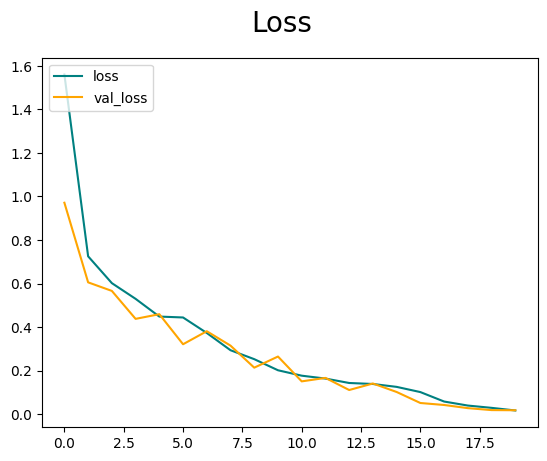

In [47]:

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

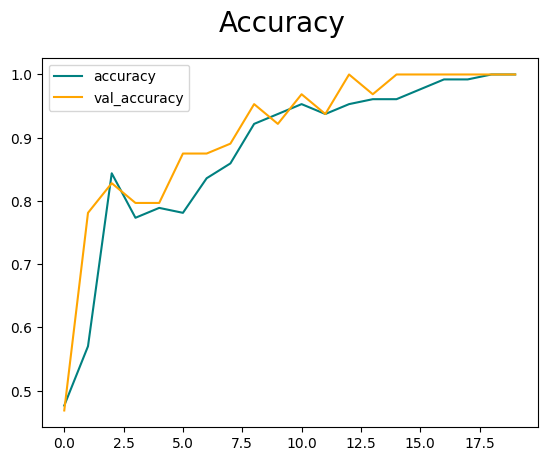

In [48]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate

In [49]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [50]:

pre = Precision()
re = Recall()
acc = BinaryAccuracy()


1

In [60]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [61]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')


Precision: 1.0, Recall: 1.0, Accuracy: 1.0


Test

In [52]:

import cv2

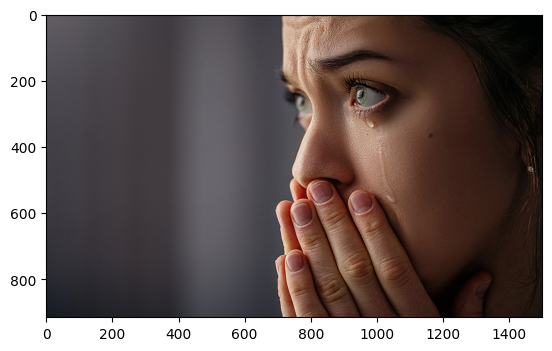

In [80]:
img = cv2.imread('sadtest.jpg.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


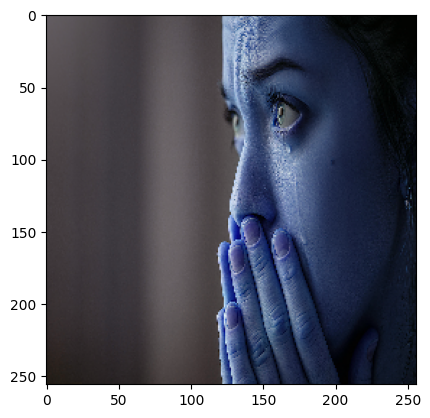

In [81]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [82]:
yhat = model.predict(np.expand_dims(resize/255, 0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [83]:
yhat


array([[0.9988763]], dtype=float32)

In [84]:

if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')


Predicted class is Sad


Save the model

In [85]:
from tensorflow.keras.models import load_model


In [87]:
model.save(os.path.join('models','imageclassifiercnn.keras'))


In [90]:
new_model = load_model(os.path.join('models','imageclassifiercnn.keras'))

c:\Users\akash\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [92]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[0.9988763]], dtype=float32)